### Simulating a Homotetramer from a PDB Structure 
#### Generating a NERDSS Model from a PDB Structure Using ioNERDSS

In [ ]:
import ionerdss as ion

# 1. Initialize the Model: 
pdb_id = '8y7s'
save_folder = '~/Documents/8y7s_dir'

pdb_model = ion.PDBModel(
    pdb_id=pdb_id, 
    save_dir=save_folder
    )

# 2. Coarse-Grain the Structure:
pdb_model.coarse_grain(
    distance_cutoff=0.35,
    residue_cutoff=3,
    show_coarse_grained_structure=False,
    save_pymol_script=False,
    standard_output=False
    )

# 3. Regularize repeated subunits:
pdb_model.regularize_repeated_subunits(
    dist_threshold_intra=3.5,
    dist_threshold_inter=3.5,
    angle_threshold=25.0,
    show_coarse_grained_structure=False,
    save_pymol_script=True,
    standard_output=False
    )



Successfully downloaded assembly file: /Users/sikao/Documents/8y7s_dir/8y7s-assembly1.cif.gz
Header parsing results appear invalid, falling back to sequence alignment...
Homologous chains identified using sequence alignment:
{'A': 'A', 'E': 'A', 'F': 'A', 'B': 'A'}
1 homologous chain groups identified:
[['A', 'B', 'E', 'F']]
Regularized coarse-grained structure saved to /Users/sikao/Documents/8y7s_dir/regularized_coarse_grained_structure.cif.
PyMOL script saved to /Users/sikao/Documents/8y7s_dir/visualize_regularized_coarse_grained.pml.
Model saved successfully to /Users/sikao/Documents/8y7s_dir/8y7s_model.json


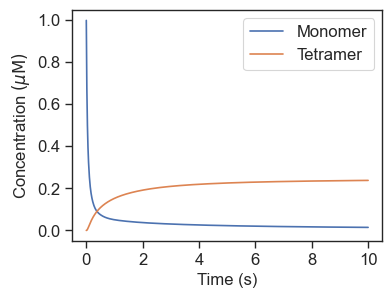

In [6]:
from ionerdss import ParseComplexes
from ionerdss import ReactionStringParser
from ionerdss import solve_reaction_ode, reaction_dydt
import numpy as np

complex_list, complex_reaction_system = ParseComplexes(pdb_model)

# initialize an instance of reaction_string_parser
rsp = ReactionStringParser()

reaction_strings = [reaction.expression for reaction in complex_reaction_system.reactions]
species_names, rate_constant_names, reactant_matrix, product_matrix = rsp.parse_reaction_strings(reaction_strings)

# Rate constant assuming already non-dimensionalized
rate_constants = [reaction.rate for reaction in complex_reaction_system.reactions]

# Define time span and initial concentration, assuming already non-dimensionalized
t_span = [0.0, 10.0]
y_init = np.zeros(len(complex_list)) # initial concentration
y_init[0] = 1.0 # initial monomer concentration

time, concentrations, species_names = solve_reaction_ode(
    reaction_dydt, t_span,  y_init, reactant_matrix = reactant_matrix, product_matrix = product_matrix,
    k = rate_constants, plotting=False, method = "BDF", species_names = species_names
    )

import matplotlib.pyplot as plt

plt.plot(time,((concentrations.T)[0]).T, label='Monomer')
# Plotting the concentrations of Tetramer, sum of 1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,24
indices = [1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,24]
plt.plot(time,((concentrations.T)[indices]).T.sum(axis=1), label='Tetramer')
plt.xlabel('Time (s)')
plt.ylabel(r'Concentration $\left(\mu\mathrm{M}\right)$')
plt.legend()

#### Run NERDSS Simulation Using ioNERDSS

In [ ]:
# 1. Generate Input Files: 
simulation = ion.Simulation(
    pdb_model, save_folder
    )
simulation.generate_nerdss_input()

# 2. Modify Simulation Parameters: 
simulation.modify_inp_file(
    {'nItr': 20000000, 'timeStep': 0.5,
    'timeWrite': 20000, 'trajWrite': 2000000,
    'pdbWrite': 2000000, 'A': 130,
    'WaterBox': [600.0, 600.0, 600.0]}
    )

# 3. Launch simulations: 
nerdss_install_path="~/NERDSS/"
simulation.run_new_simulations(
    sim_indices=[1],
    sim_dir=f"{save_folder}/nerdss_output",
    nerdss_dir=nerdss_install_path,
    parallel=False
    )



Working directory set to: /Users/sikao/Documents/8y7s_dir
Running simulation 1...


Simulation 1:   0%|          | 0/100 [15:59<?, ?it/s]


Processed data saved to /Users/sikao/Documents/8y7s_dir/nerdss_output/figure_plot_data/complex_count_vs_time.csv
Plot saved to /Users/sikao/Documents/8y7s_dir/nerdss_output/figure_plot_data/complex_count_vs_time.svg


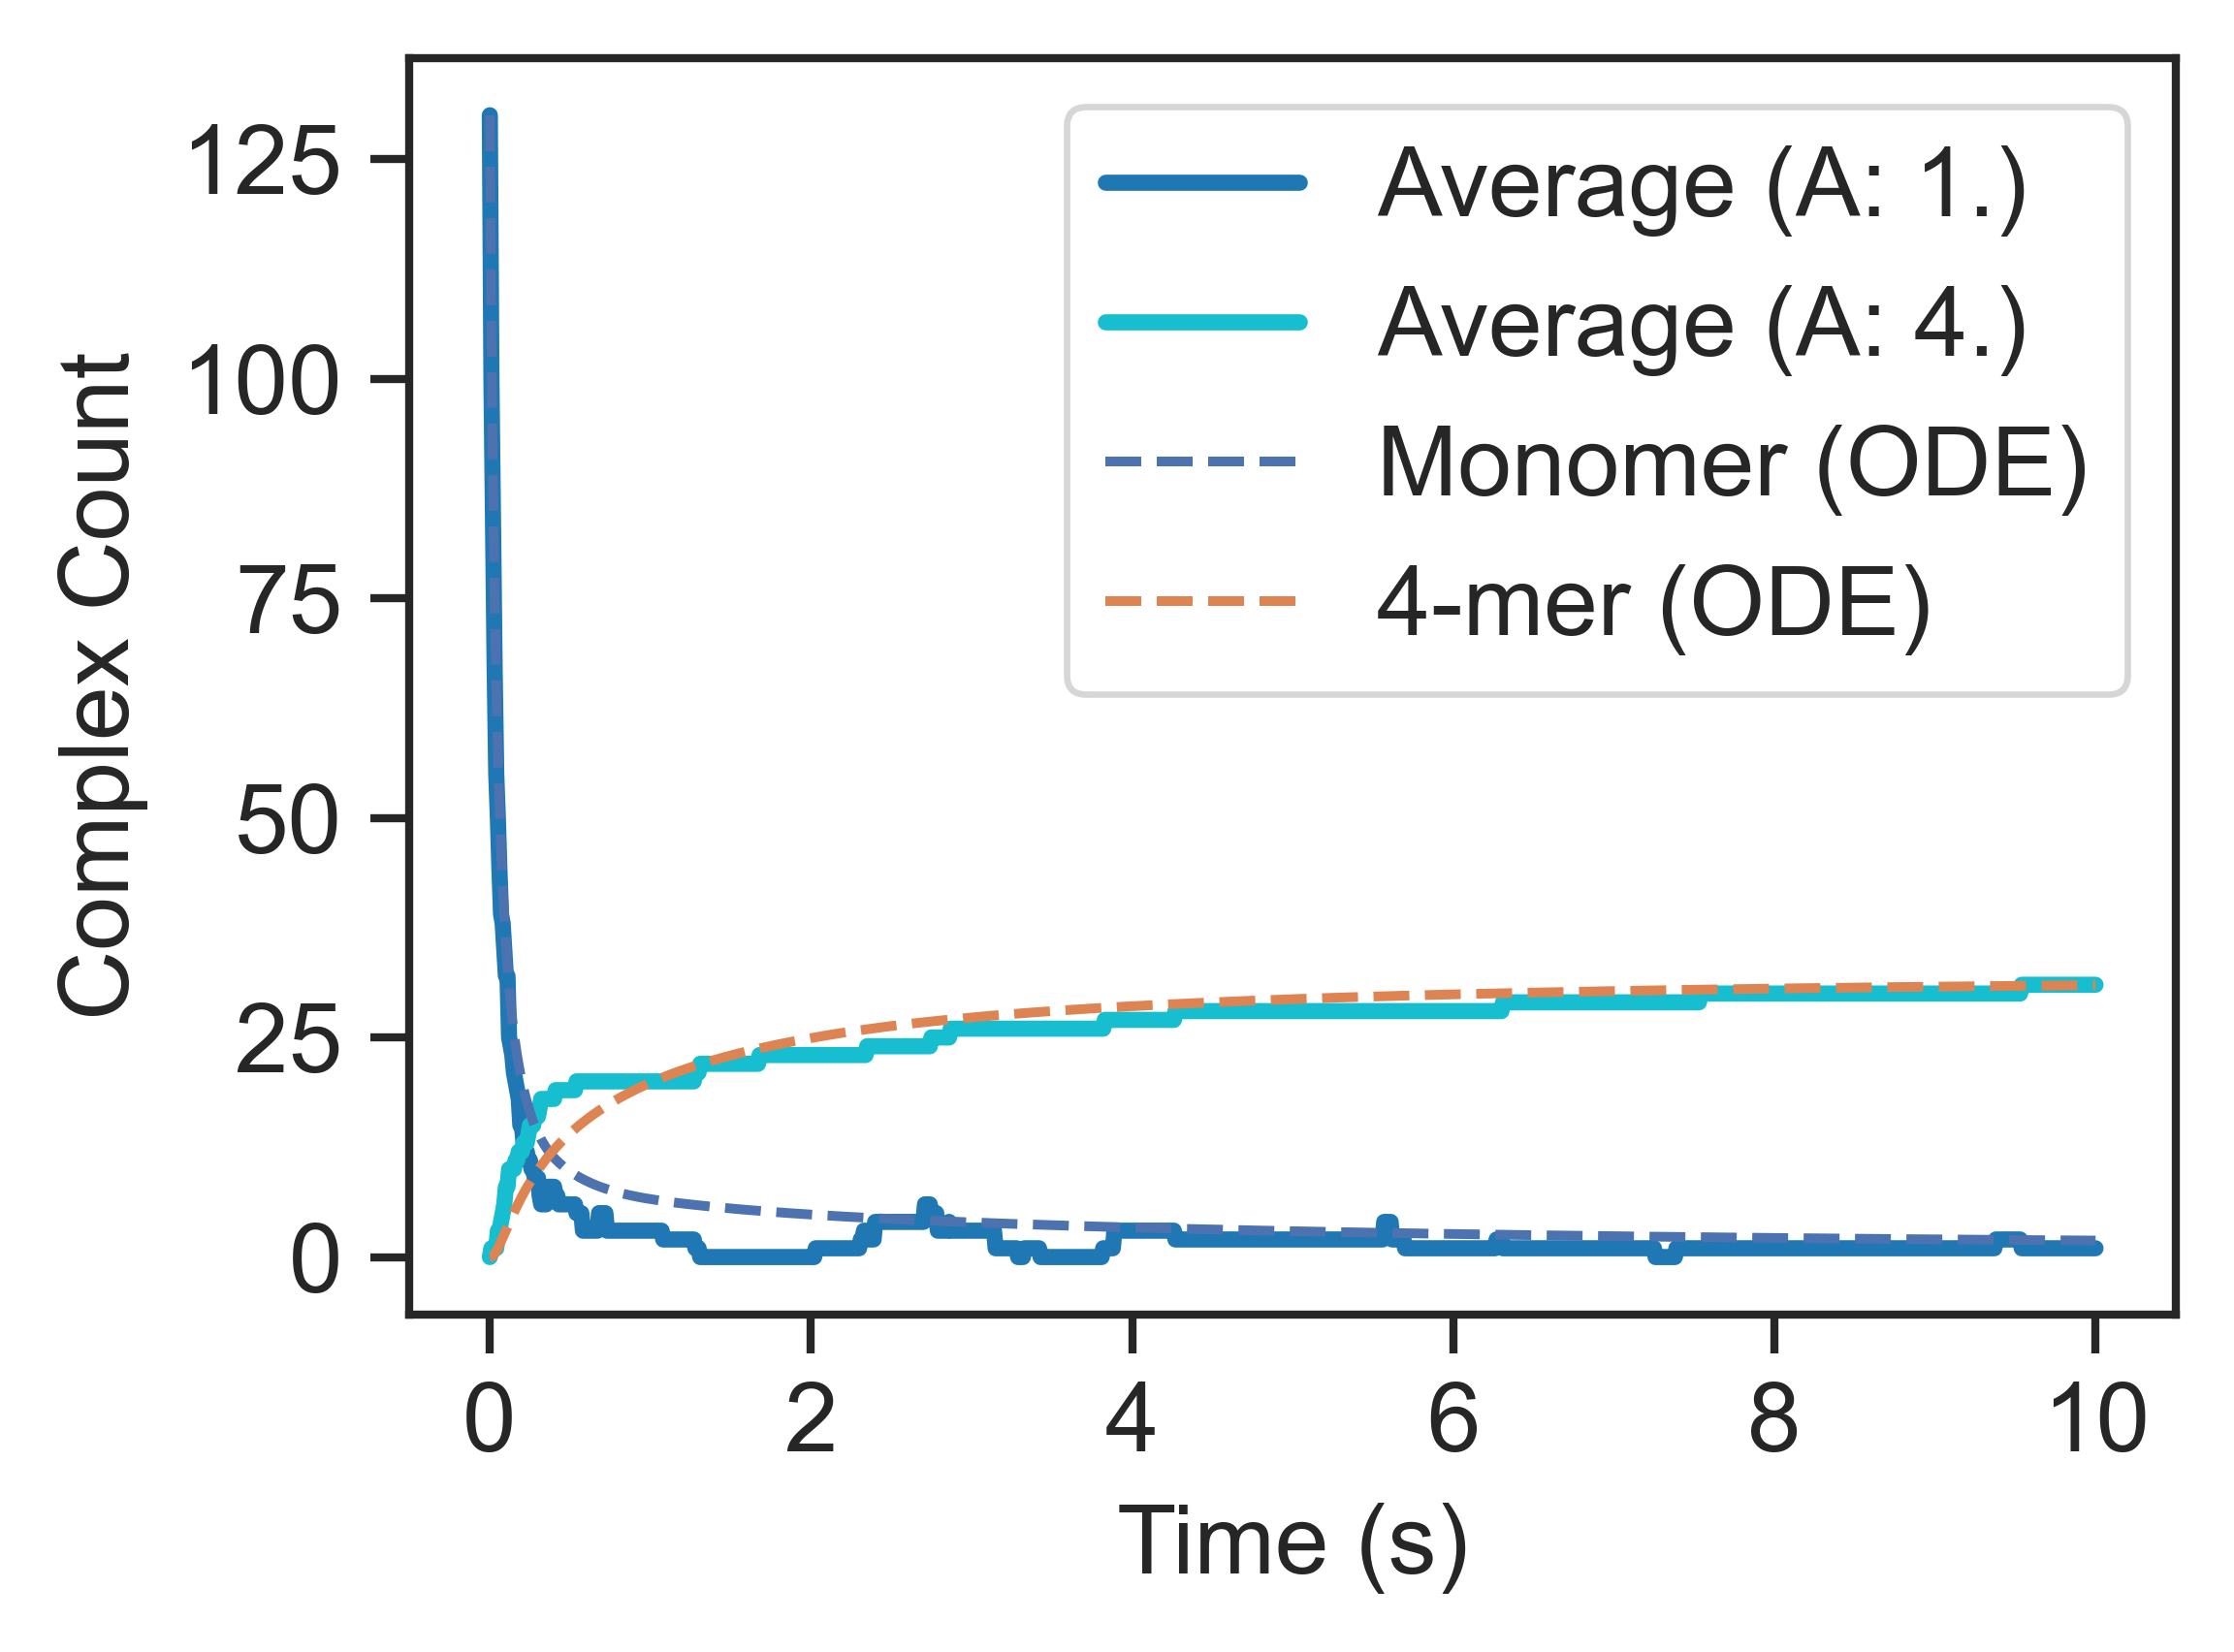

In [8]:
# 1. Analyze NERDSS Simulation Output:
analysis = ion.Analysis(
    f"{save_folder}/nerdss_output"
    )

analysis.plot_figure(
    figure_type='line',
    x='time',
    y='count',
    legend=["A: 1.", "A: 4.",],
    show_type='average',
    figure_size = (4, 3)
    )

plt.plot(time,((concentrations.T)[0]).T * 130, '--', label='Monomer (ODE)')
# Plotting the concentrations of Tetramer, sum of 1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,24
indices = [1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,24]
plt.plot(time,((concentrations.T)[indices]).T.sum(axis=1) * 130, '--', label='4-mer (ODE)')

plt.legend()